# Transformation with TPS and Structured Grid
- Here is the example code to illustrate the transformation of a structured grid using Thin Plate Spline (TPS) interpolation.
- We randomly picked a bone for visualization purposes.
- To apply the method to real bone, please follow the steps under the README section.

In [11]:
from utils import *
from matplotlib import pyplot as plt

## 1. Set parameters

In [12]:
# Parameters
bone_of_interest = "20mo"
num_of_cells = 4000 # Recommend: 2000 - 20000, please note the number of cells inside the outline will be less than this number
horizontal_line = True # (Optional) True or False, add horizontal line to better visualize the transformation
resolution = 8   # Recommend: 5-20 for better visualization

## 2. Visulalize the bone outline of interest and reference bone outline

In [13]:
ref_outline = np.load('examples/ref_outline.npy')
test_bone_outline = np.load('examples/bone_outline_20mo_st4.npy')

In [14]:
# Plot the outlines
def plot_outline(outline, title):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    ax.plot(outline[:, 0], outline[:, 1], 'black')
    if title:
        ax.set_title(title)
    else:
        ax.set_title('Bone Outline')
    plt.tight_layout()
    plt.show()


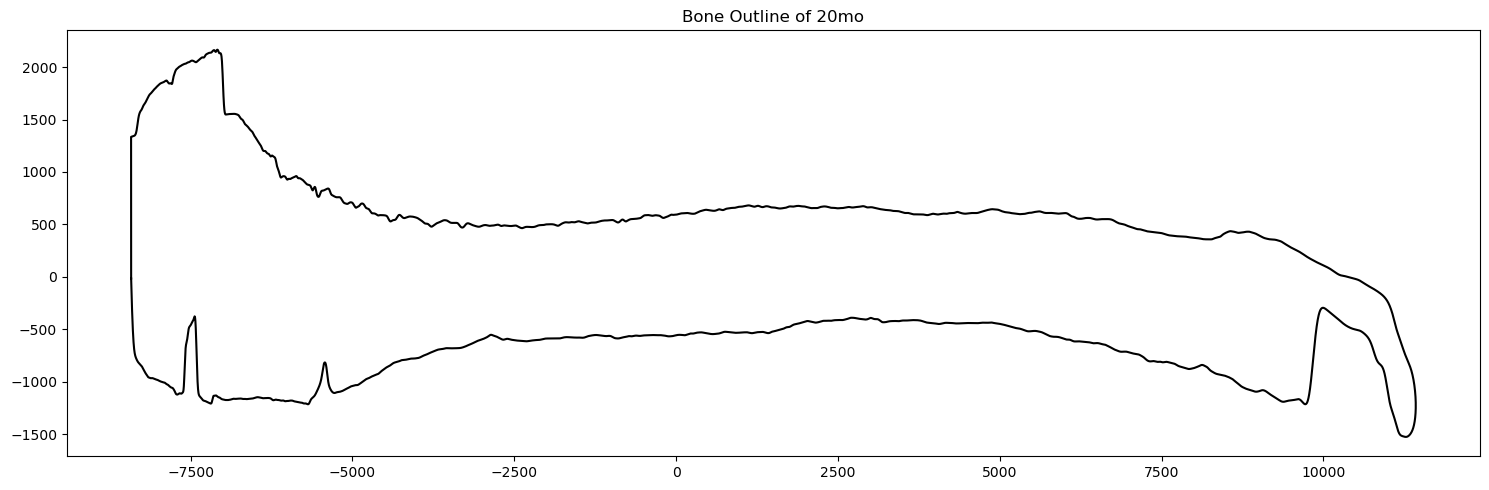

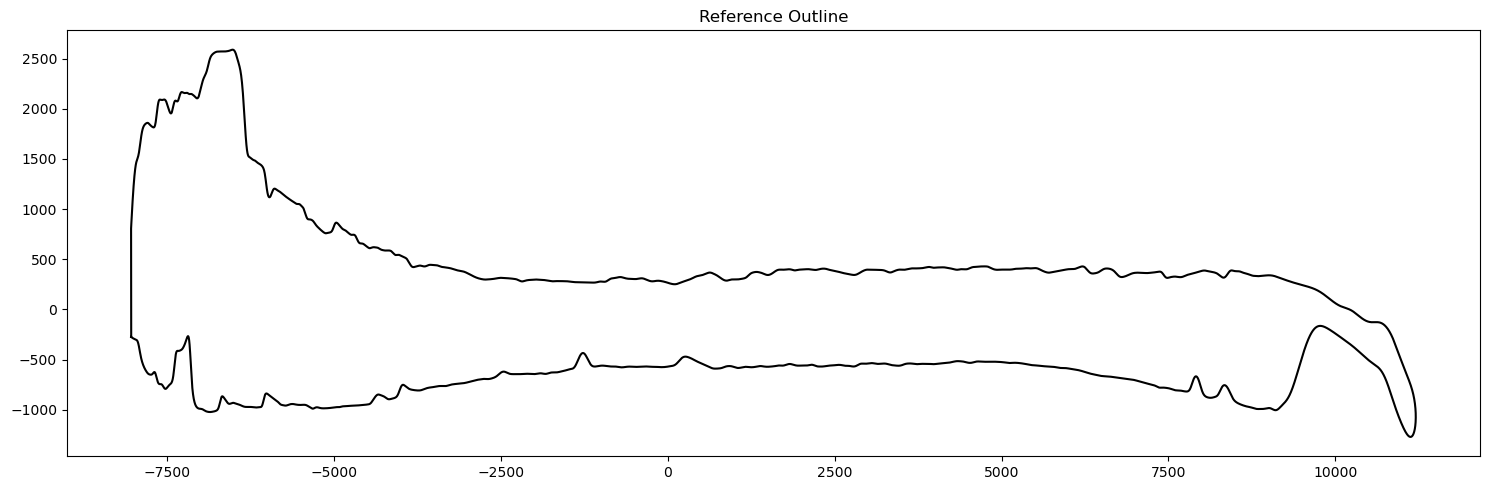

In [15]:
# Plot bone outlines
plot_outline(test_bone_outline, f'Bone Outline of {bone_of_interest}')
# Plot reference outline
plot_outline(ref_outline, 'Reference Outline')

## 3. Generate data points

In [16]:
# Get the bounding box
def get_bounding_box(outline):
    min_x = np.min(outline[:, 0])
    max_x = np.max(outline[:, 0])
    min_y = np.min(outline[:, 1])
    max_y = np.max(outline[:, 1])
    return min_x, max_x, min_y, max_y

# Generate random points inside the bounding box, the output should be a dataframe with three columns (Position.X, Position.Y, source = "random")
def generate_random_points(min_x, max_x, min_y, max_y, num_points):
    x = np.random.uniform(min_x, max_x, num_points)
    y = np.random.uniform(min_y, max_y, num_points)
    points = np.column_stack((x, y))
    points_df = pd.DataFrame(points, columns=['Position.X', 'Position.Y'])
    points_df['source'] = 'random'
    return points_df


# Generate a horizontal line
def generate_horizontal_line(min_x, max_x, y_value, num_points):
    x = np.linspace(min_x, max_x, num_points)
    y = np.full_like(x, y_value)
    line = np.column_stack((x, y))
    line_df = pd.DataFrame(line, columns=['Position.X', 'Position.Y'])
    line_df['source'] = 'horizontal line'
    return line_df

# Generate desired data points
# For this purpose, you just need to create a data frame with three columns (Position.X, Position.Y, source = "random")

    

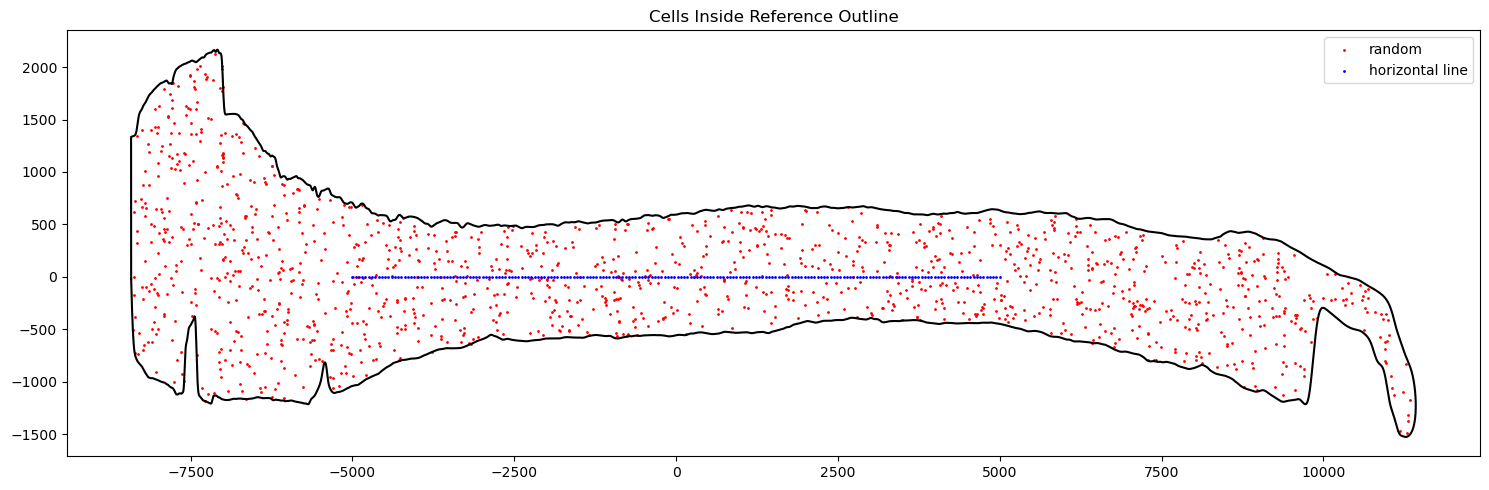

In [17]:
# generate 2000 random points as the data that we want to transform
min_x, max_x, min_y, max_y = get_bounding_box(test_bone_outline)
num_points = num_of_cells
random_points = generate_random_points(min_x, max_x, min_y, max_y, num_points)
random_points = exclude_outside_bone_outline(random_points, test_bone_outline)
if horizontal_line:
    h_line = generate_horizontal_line(-5000, 5000, 0, 200)
else:
    h_line = pd.DataFrame(columns=['Position.X', 'Position.Y', 'source'])


# Concatenate the random points and the horizontal line
data_points = pd.concat([random_points, h_line], ignore_index=True)

# Plot the random points with the reference outline
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(test_bone_outline[:, 0], test_bone_outline[:, 1], 'black')
for source in data_points['source'].unique():
    subset = data_points[data_points['source'] == source]
    ax.scatter(subset['Position.X'], subset['Position.Y'], s=1, alpha=1, label=source, c='red' if source == 'random' else 'blue')

ax.set_title('Cells Inside Reference Outline')
ax.legend()

plt.tight_layout()
plt.show()

## 4. Generate a structured grid for transformation

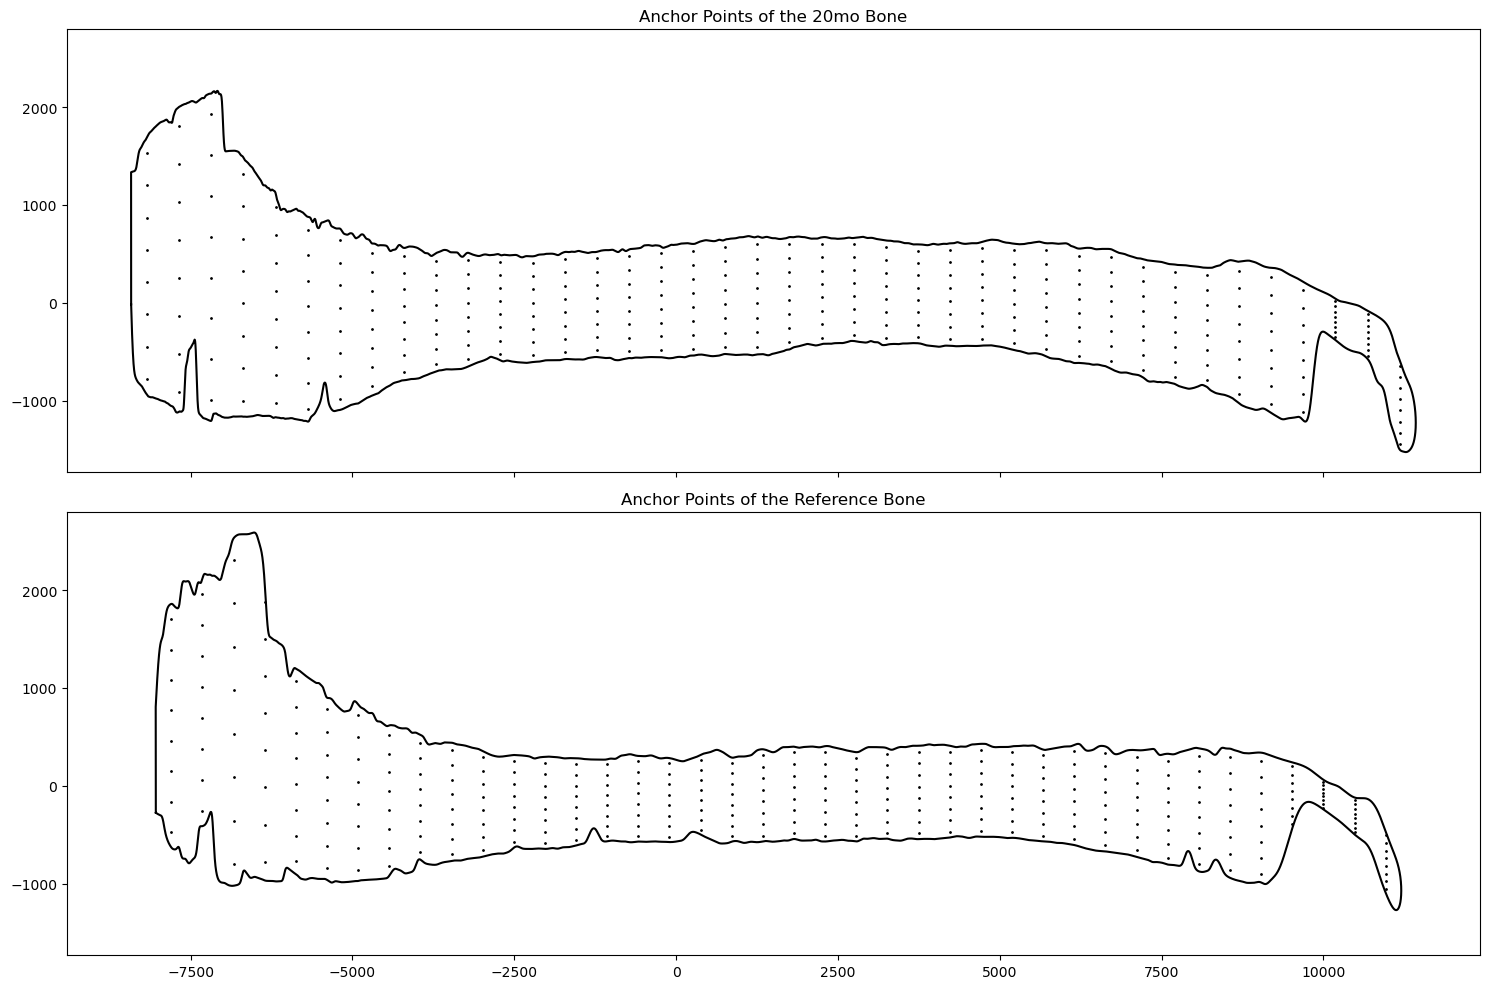

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True, sharey=True)

grid_points_interested = create_structured_grid(test_bone_outline, x_num=resolution*5, y_num=resolution)
ax[0].scatter(grid_points_interested[:, 0], grid_points_interested[:, 1], s=1, color='black', alpha=1)
ax[0].plot(test_bone_outline[:, 0], test_bone_outline[:, 1],  color='black')

grid_points_ref = create_structured_grid(ref_outline, x_num=resolution*5, y_num=resolution)
ax[1].scatter(grid_points_ref[:, 0], grid_points_ref[:, 1], s=1, color='black', alpha=1)
ax[1].plot(ref_outline[:, 0], ref_outline[:, 1],  color='black')
ax[0].set_title(f'Anchor Points of the {bone_of_interest} Bone')
ax[1].set_title('Anchor Points of the Reference Bone')
plt.tight_layout()
plt.show()


## 5. Transformation of the data to the reference bone

In [19]:
test_bone_outline_dict = {bone_of_interest: test_bone_outline}
test_bone_data = {bone_of_interest: data_points}
# Transform the random points using the reference outlin
transformed_bones = transform_bone_positions(test_bone_outline_dict, test_bone_data, ref_outline, x_num=resolution*5, y_num=resolution)

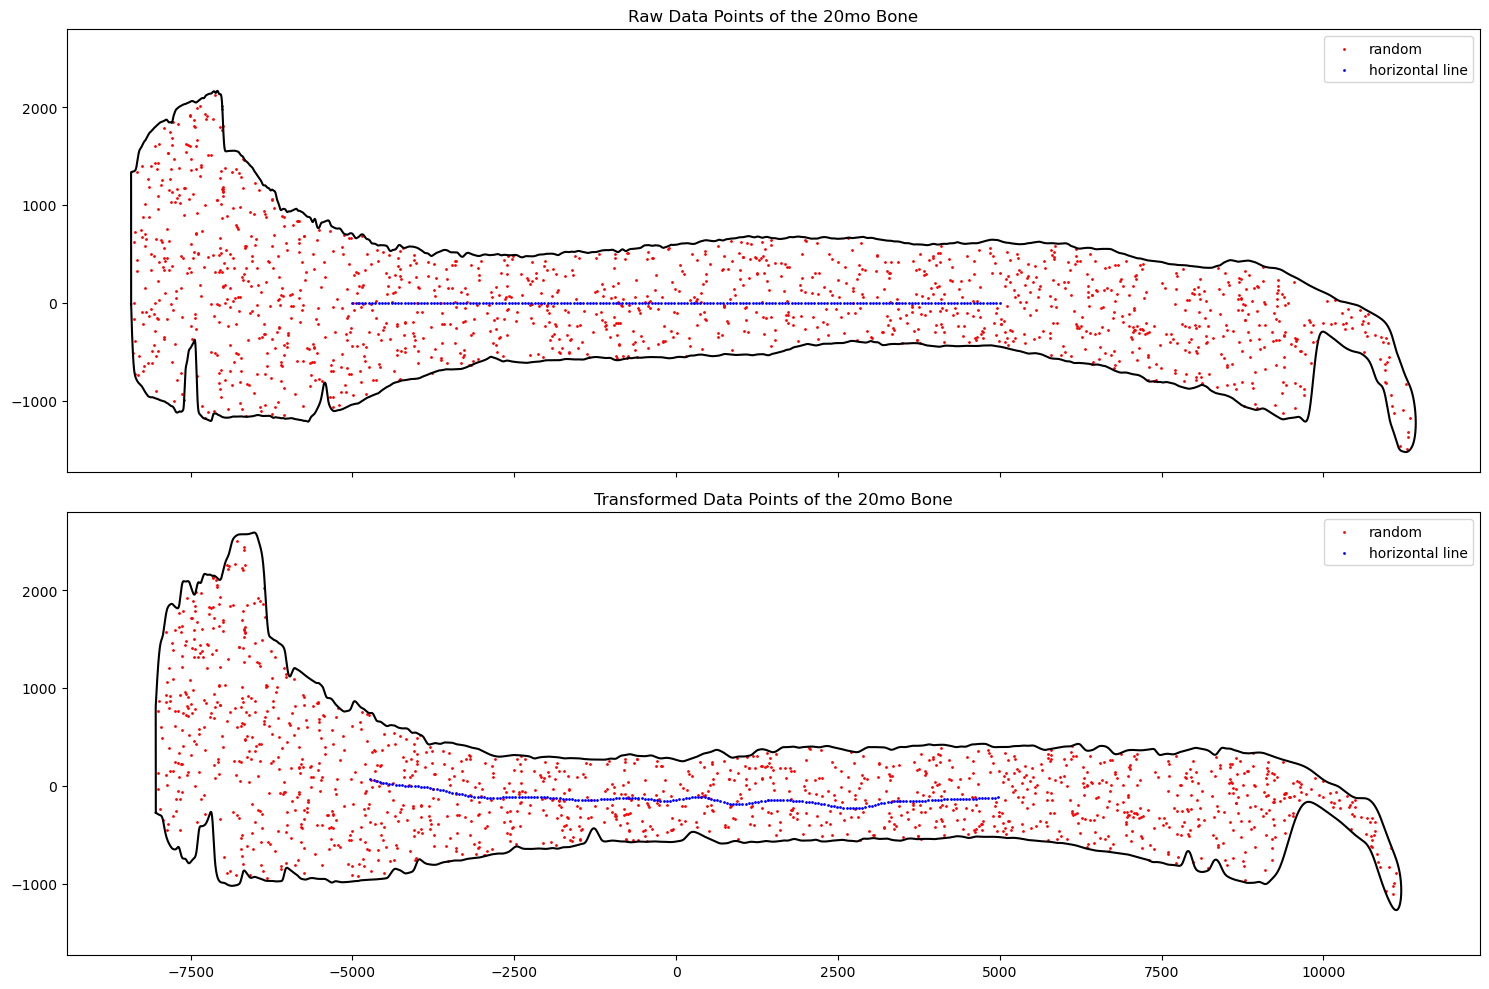

In [20]:
transformed_bones_in = exclude_outside_bone_outline(transformed_bones[bone_of_interest], ref_outline)
fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True, sharey=True)
ax[0].plot(test_bone_outline[:, 0], test_bone_outline[:, 1], 'black')
for source in data_points['source'].unique():
    subset = data_points[data_points['source'] == source]
    ax[0].scatter(subset['Position.X'], subset['Position.Y'], s=1, alpha=1, label=source, c='red' if source == 'random' else 'blue')
ax[0].set_title(f'Raw Data Points of the {bone_of_interest} Bone')
ax[0].legend()

ax[1].plot(ref_outline[:, 0], ref_outline[:, 1], 'black')
for source in transformed_bones_in['source'].unique():
    subset = transformed_bones_in[transformed_bones_in['source'] == source]
    ax[1].scatter(subset['Position.X'], subset['Position.Y'], s=1, alpha=1, label=source, c='red' if source == 'random' else 'blue')
ax[1].set_title(f'Transformed Data Points of the {bone_of_interest} Bone')
ax[1].legend()
plt.tight_layout()
plt.show()